# 02 Classification of synthetic time series data
In this notebook, we aim to
1. Synthesise some *simple* time series data using the telegraph model, with two different labels e.g., normal and stressful conditions for the cells. The signals need to be produced as similarly to each other as much as possible so that it ressembles microfluidic time series data, and are harder for the ML algorithm to classify.
2. Classify these two conditions with an ML algorithm e.g, Support Vector Machine (SVM).

## Define some SSA functions

In [1]:
import matplotlib.pyplot as plt
import multiprocessing
import tqdm
import numpy as np
import pandas as pd
import os
import scipy.stats as st
import numba
import biocircuits
import itertools

# Define the update matrix for the reactions
# Columns: G, G*, M
# Columns: G, G*, M
update_matrix = np.array([
    [-1, 1, 0],   # G -> G* (Gene activation)
    [1, -1, 0],   # G* -> G (Gene deactivation)
    [0, 0, 1],    # G -> G + M (mRNA production)
    [0, 0, -1],   # M -> 0 (mRNA degradation)
], dtype=int)

def telegraph_model_propensity(propensities, population, t, sigma_u, sigma_b, rho, d):
    """
    Updates the propensities for the telegraph model reactions based on defined rates.

    Parameters:
        propensities: Array of propensities
        population: Array of species populations [G, G*, M]
        t: Time (not used but required by signature)
        sigma_u: Rate of G -> G* (deactivation)
        sigma_b: Rate of G* -> G (activation)
        rho: Rate of G -> G + M (mRNA production)
        d: Rate of M -> 0 (mRNA degradation)
    """
    # Unpack population
    G, G_star, M = population
    
    # Update propensities for each reaction
    propensities[0] = sigma_u * G          # G -> G*
    propensities[1] = sigma_b * G_star     # G* -> G
    propensities[2] = rho * G              # G -> G + M
    propensities[3] = d * M                # M -> 0

def sample_discrete_scipy(probs):
    """Randomly sample an index with probability given by probs."""
    return st.rv_discrete(values=(range(len(probs)), probs)).rvs()

def sample_discrete(probs):
    """Randomly sample an index with probability given by probs."""
    # Generate random number
    q = np.random.rand()
    
    # Find index
    i = 0
    p_sum = 0.0
    while p_sum < q:
        p_sum += probs[i]
        i += 1
    return i - 1

def gillespie_draw(propensity_func, propensities, population, t, args=()):
    """
    Draws a reaction and the time it took to do that reaction.
    
    Parameters
    ----------
    propensity_func : function
        Function with call signature propensity_func(population, t, *args)
        used for computing propensities. This function must return
        an array of propensities.
    population : ndarray
        Current population of particles
    t : float
        Value of the current time.
    args : tuple, default ()
        Arguments to be passed to `propensity_func`.
        
    Returns
    -------
    rxn : int
        Index of reaction that occured.
    time : float
        Time it took for the reaction to occur.
    """
    # Compute propensities
    propensity_func(propensities, population, t, *args)
    
    # Sum of propensities
    props_sum = propensities.sum()
    
    # Compute next time
    time = np.random.exponential(1.0 / props_sum)
    
    # Compute discrete probabilities of each reaction
    rxn_probs = propensities / props_sum
    
    # Draw reaction from this distribution
    rxn = sample_discrete(rxn_probs)
    
    return rxn, time

def gillespie_ssa(propensity_func, update, population_0, time_points, args=()):
    """
    Uses the Gillespie stochastic simulation algorithm to sample
    from probability distribution of particle counts over time.
    
    Parameters
    ----------
    propensity_func : function
        Function of the form f(params, t, population) that takes the current
        population of particle counts and return an array of propensities
        for each reaction.
    update : ndarray, shape (num_reactions, num_chemical_species)
        Entry i, j gives the change in particle counts of species j
        for chemical reaction i.
    population_0 : array_like, shape (num_chemical_species)
        Array of initial populations of all chemical species.
    time_points : array_like, shape (num_time_points,)
        Array of points in time for which to sample the probability
        distribution.
    args : tuple, default ()
        The set of parameters to be passed to propensity_func.        

    Returns
    -------
    sample : ndarray, shape (num_time_points, num_chemical_species)
        Entry i, j is the count of chemical species j at time
        time_points[i].
    """

    # Initialize output
    pop_out = np.empty((len(time_points), update.shape[1]), dtype=int)

    # Initialize and perform simulation
    i_time = 1
    i = 0
    t = time_points[0]
    population = population_0.copy()
    pop_out[0,:] = population
    propensities = np.zeros(update.shape[0])
    while i < len(time_points):
        while t < time_points[i_time]:
            # draw the event and time step
            event, dt = gillespie_draw(propensity_func, propensities, population, t, args)
                
            # Update the population
            population_previous = population.copy()
            population += update[event,:]
                
            # Increment time
            t += dt

        # Update the index
        i = np.searchsorted(time_points > t, True)
        
        # Update the population
        pop_out[i_time:min(i,len(time_points))] = population_previous
        
        # Increment index
        i_time = i
                           
    return pop_out

## Simulate two different systems with the same mean so that the 2 time series are similar
System 1: Normal Condition (σ_u_normal = 9.0, σ_b_normal = 0.02)
System 2: Carbon Stress (σ_u_stress = 18.0, σ_b_stress = 0.01)
- Higher gene deactivation rate: genes encoding metabolic enzymes under stress do not stay active for long.
- Lower gene activation rate: stress often results in strong repression of transcription by repressors, which makes gene activation rarer

This combination will lead to lower mRNA levels.

In [ ]:
import numpy as np
import pandas as pd
import tqdm
import multiprocessing

# Define target mean mRNA count (ensuring similarity between conditions)
mu_target = 10.0  

# Define activation/deactivation rates for two conditions
sigma_u_stress, sigma_b_stress = 18.0, 0.01  # Carbon Stress
sigma_u_normal, sigma_b_normal = 9.0, 0.02   # Normal Condition

# Compute corresponding transcription rates (rho) using the given formula
rho_stress = (mu_target * (sigma_u_stress + sigma_b_stress)) / sigma_b_stress
rho_normal = (mu_target * (sigma_u_normal + sigma_b_normal)) / sigma_b_normal

# Define degradation rates
d_stress, d_normal = 0.12, 0.12  

# Updated parameter sets ensuring similar mean mRNA levels
parameter_sets = [
    {"sigma_u": sigma_u_stress, "sigma_b": sigma_b_stress, "rho": rho_stress, "d": d_stress, "label": 0},  # Carbon Stress Condition
    {"sigma_u": sigma_u_normal, "sigma_b": sigma_b_normal, "rho": rho_normal, "d": d_normal, "label": 1},   # Normal Condition
]

# Set up simulation parameters !! use np.arange to make sure evenly spaced values within a given interval!!
time_points = np.arange(0, 200.0, 1.0)  # Time range: start, stop, step; 

size = 500  # Reduce number of simulations per condition for efficiency

# Ensure steady state condition is met
for params in parameter_sets:
    if time_points[-1] < 10 / params["d"]:
        time_points = np.linspace(0, 10 / params["d"], int(10 / params["d"] * 10) + 1)

# Initialize storage for results
results = []

# Worker function to run simulations
def run_simulation(param_set):
    sigma_u, sigma_b, rho, d, label = param_set.values()
    population_0 = np.array([1, 0, 0], dtype=int)  # Initial [G, G*, M]

    # Store mRNA trajectories
    samples = np.empty((size, len(time_points)), dtype=int)

    for i in range(size):
        samples[i, :] = gillespie_ssa(
            telegraph_model_propensity, update_matrix, population_0, time_points,
            args=(sigma_u, sigma_b, rho, d))[:, 2]  # Extract mRNA counts

    # Save each trajectory as a row with label
    return [[label] + list(trajectory) for trajectory in samples]

num_cores = multiprocessing.cpu_count()  # Get available CPU cores
# Use multiprocessing to accelerate simulations
with multiprocessing.Pool(num_cores) as pool:
    print(f"Running simulations on {num_cores} cores...") 
    results = list(tqdm.tqdm(pool.imap(run_simulation, parameter_sets), total=len(parameter_sets), desc="Simulating Systems"))

# Flatten results
results = [item for sublist in results for item in sublist]

# Convert to DataFrame and save
columns = ["label"] + [f"time_{t}" for t in time_points]
df_results = pd.DataFrame(results, columns=columns)

# Save dataset for ML classification
output_file = "traj_data/mRNA_trajectories.csv"
df_results.to_csv(output_file, index=False)

Running simulations on 12 cores...


Simulating Systems: 100%|██████████| 2/2 [00:39<00:00, 19.76s/it]


Visualise the time series generated - they should be quite similar

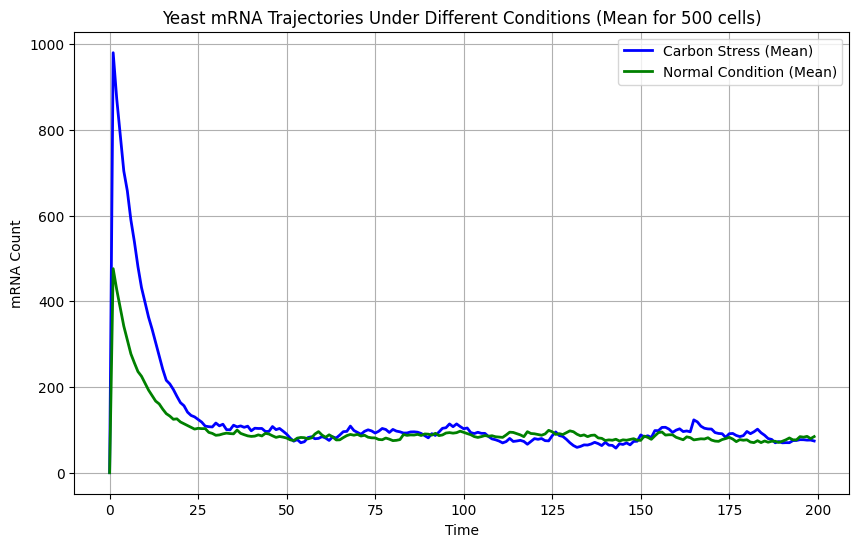

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Extract mRNA trajectories for each condition
stress_trajectories = df_results[df_results['label'] == 0].iloc[:, 1:].values  # Carbon stress
normal_trajectories = df_results[df_results['label'] == 1].iloc[:, 1:].values  # Normal condition

# Plot mRNA trajectories
fig, ax = plt.subplots(figsize=(10, 6))

# Plot mean trajectory for each condition
ax.plot(time_points, stress_trajectories.mean(axis=0), color='blue', label='Carbon Stress (Mean)', linewidth=2)
ax.plot(time_points, normal_trajectories.mean(axis=0), color='green', label='Normal Condition (Mean)', linewidth=2)

# Labels and legend
ax.set_xlabel("Time")
ax.set_ylabel("mRNA Count")
ax.set_title(f"Yeast mRNA Trajectories Under Different Conditions (Mean for {size} cells)")
ax.legend()
ax.grid(True)

# Show plot
plt.show()

SVM to classify the two different environments, ideally we'd like to make things difficult for them to distinguish

SVM Classification Accuracy: 0.73


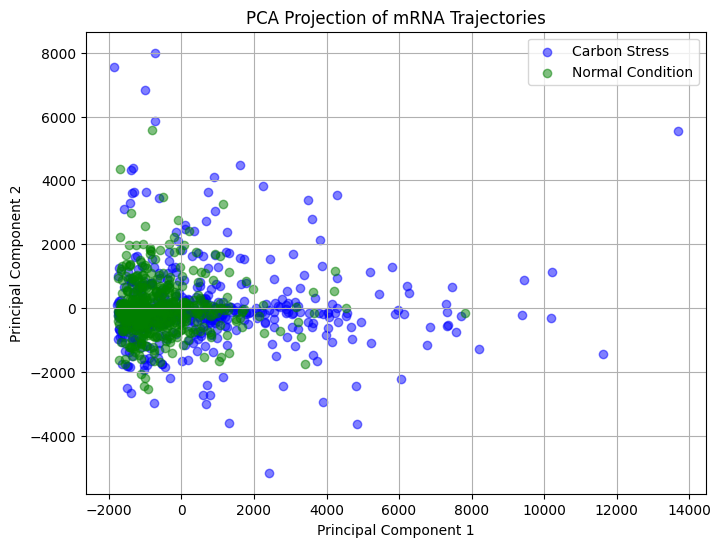

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Load the mRNA trajectories dataset
df_results = pd.read_csv("~/stochastic_simulations/SSA_telegraph_model/traj_data/mRNA_trajectories.csv")

# Extract features (mRNA trajectories) and labels
X = df_results.iloc[:, 1:].values  # All time series data
y = df_results["label"].values  # Labels: 0 (Carbon Stress) or 1 (Normal Condition)

# Split data into training and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a basic SVM model without grid search
svm_model = SVC(C=1.0, gamma='scale', kernel='rbf')
svm_model.fit(X_train, y_train)

# Evaluate the model
y_pred = svm_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"SVM Classification Accuracy: {accuracy:.2f}")

# Scatter plot of two PCA components for visualization
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[y == 0, 0], X_pca[y == 0, 1], color='blue', label='Carbon Stress', alpha=0.5)
plt.scatter(X_pca[y == 1, 0], X_pca[y == 1, 1], color='green', label='Normal Condition', alpha=0.5)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Projection of mRNA Trajectories")
plt.legend()
plt.grid(True)
plt.show()

## Making the time series difficult to differentiate 
- The first plot (mRNA mean trajectories) **looks quite similar**, which suggests that on a broad level, both conditions **produce similar mean expression dynamics**.
- However, in the PCA scatter plot, we see **some separation**, meaning SVM **still finds discriminative features**.

Next, I need to synthesise some data that is much more difficult for the SVM to classify. Here are the steps:

### Introduce noise in both conditions
- Increase stochasticity to **blur temporal structure** in classification.

In [9]:
import numpy as np
import pandas as pd
import tqdm
import multiprocessing

# Define target mean mRNA count (ensuring similarity between conditions)
mu_target = 10.0  

# Define activation/deactivation rates for two conditions
sigma_u_stress, sigma_b_stress = 18.0, 0.01  # Carbon Stress
sigma_u_normal, sigma_b_normal = 9.0, 0.02   # Normal Condition

# Compute corresponding transcription rates (rho) using the given formula
rho_stress = (mu_target * (sigma_u_stress + sigma_b_stress)) / sigma_b_stress
rho_normal = (mu_target * (sigma_u_normal + sigma_b_normal)) / sigma_b_normal

# Define degradation rates (introducing slight stochastic noise)
d_stress = d_normal = 0.12 + np.random.uniform(-0.01, 0.01)

# Updated parameter sets ensuring similar mean mRNA levels
parameter_sets = [
    {"sigma_u": sigma_u_stress, "sigma_b": sigma_b_stress, "rho": rho_stress, "d": d_stress, "label": 0},  # Carbon Stress Condition
    {"sigma_u": sigma_u_normal, "sigma_b": sigma_b_normal, "rho": rho_normal, "d": d_normal, "label": 1},   # Normal Condition
]

# Set up simulation parameters !! use np.arange to make sure evenly spaced values within a given interval!!
time_points = np.arange(0, 200.0, 1.0)  # Time range: start, stop, step; 
size = 500  # Reduce number of simulations per condition for efficiency

# Ensure steady state condition is met
for params in parameter_sets:
    if time_points[-1] < 10 / params["d"]:
        time_points = np.linspace(0, 10 / params["d"], int(10 / params["d"] * 10) + 1)

# Initialize storage for results
results = []

# Worker function to run simulations
def run_simulation(param_set):
    sigma_u, sigma_b, rho, d, label = param_set.values()
    population_0 = np.array([1, 0, 0], dtype=int)  # Initial [G, G*, M]

    # Store mRNA trajectories
    samples = np.empty((size, len(time_points)), dtype=int)

    for i in range(size):
        samples[i, :] = gillespie_ssa(
            telegraph_model_propensity, update_matrix, population_0, time_points,
            args=(sigma_u, sigma_b, rho, d))[:, 2]  # Extract mRNA counts

    # Add Gaussian noise to blur temporal structure
    noise_level = 0.1 * np.mean(samples)
    samples += np.random.normal(0, noise_level, samples.shape).astype(int)

    # Save each trajectory as a row with label
    return [[label] + list(trajectory) for trajectory in samples]

num_cores = multiprocessing.cpu_count()  # Get available CPU cores
# Use multiprocessing to accelerate simulations
with multiprocessing.Pool(num_cores) as pool:
    print(f"Running simulations on {num_cores} cores...") 
    results = list(tqdm.tqdm(pool.imap(run_simulation, parameter_sets), total=len(parameter_sets), desc="Simulating Systems"))

# Flatten results
results = [item for sublist in results for item in sublist]

# Convert to DataFrame and save
columns = ["label"] + [f"time_{t}" for t in time_points]
df_results = pd.DataFrame(results, columns=columns)

# Save dataset for ML classification
output_file = "traj_data/mRNA_trajectories_noised.csv"
df_results.to_csv(output_file, index=False)


Running simulations on 12 cores...


Simulating Systems: 100%|██████████| 2/2 [00:47<00:00, 23.87s/it]


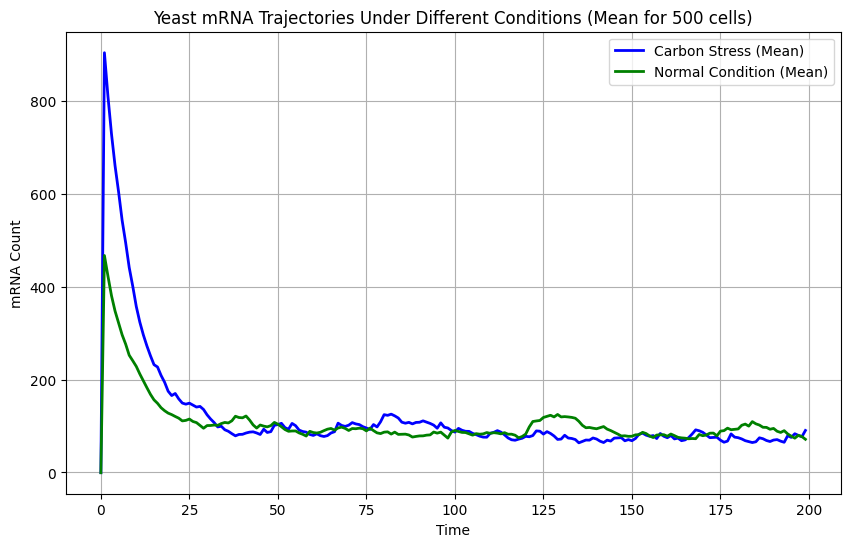

SVM Classification Accuracy: 0.70


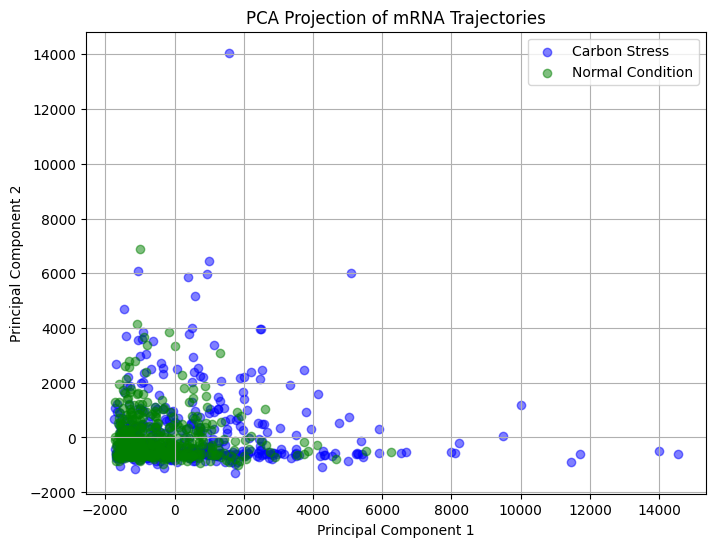

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Load the mRNA trajectories dataset
df_results = pd.read_csv("~/stochastic_simulations/SSA_telegraph_model/traj_data/mRNA_trajectories_noised.csv")

# Extract mRNA trajectories for each condition
stress_trajectories = df_results[df_results['label'] == 0].iloc[:, 1:].values  # Carbon stress
normal_trajectories = df_results[df_results['label'] == 1].iloc[:, 1:].values  # Normal condition

# Plot mRNA trajectories
fig, ax = plt.subplots(figsize=(10, 6))

# Plot mean trajectory for each condition
ax.plot(time_points, stress_trajectories.mean(axis=0), color='blue', label='Carbon Stress (Mean)', linewidth=2)
ax.plot(time_points, normal_trajectories.mean(axis=0), color='green', label='Normal Condition (Mean)', linewidth=2)

# Labels and legend
ax.set_xlabel("Time")
ax.set_ylabel("mRNA Count")
ax.set_title(f"Yeast mRNA Trajectories Under Different Conditions (Mean for {size} cells)")
ax.legend()
ax.grid(True)

# Show plot
plt.show()

#####################

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Extract features (mRNA trajectories) and labels
X = df_results.iloc[:, 1:].values  # All time series data
y = df_results["label"].values  # Labels: 0 (Carbon Stress) or 1 (Normal Condition)

# Split data into training and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a basic SVM model without grid search
svm_model = SVC(C=1.0, gamma='scale', kernel='rbf')
svm_model.fit(X_train, y_train)

# Evaluate the model
y_pred = svm_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"SVM Classification Accuracy: {accuracy:.2f}")

# Scatter plot of two PCA components for visualization
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[y == 0, 0], X_pca[y == 0, 1], color='blue', label='Carbon Stress', alpha=0.5)
plt.scatter(X_pca[y == 1, 0], X_pca[y == 1, 1], color='green', label='Normal Condition', alpha=0.5)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Projection of mRNA Trajectories")
plt.legend()
plt.grid(True)
plt.show()

### Make deactivation and activation rates more similar (with added noise)
Adjust the activation/deactivation rates to be similar but not identical, and introduce a natural variability by deciding the sigma values randomly. 
1. Reduce the difference, but still keep stress conditions distinct:
- The deactivation / activation rates are randomly picked from a uniform distribution, with different conditions being drawn from different ranges. 
- Carbon stress should still have higher gene deactivation (σ_u) and lower activation (σ_b), normal conditions should maintain more frequent activation.
2. Introduce overlapping stochastic fluctuations as was implemented in the last step

In [11]:
import numpy as np
import pandas as pd
import tqdm
import multiprocessing

# Define target mean mRNA count (ensuring similarity between conditions)
mu_target = 10.0  

# Adjust activation/deactivation rates to make stress and normal conditions similar, but not identical
sigma_u_stress = np.random.uniform(15.0, 20.0)  # Carbon Stress: higher gene deactivation
sigma_b_stress = np.random.uniform(0.008, 0.012)  # Carbon Stress: lower activation

sigma_u_normal = np.random.uniform(8.0, 12.0)  # Normal Condition: lower deactivation
sigma_b_normal = np.random.uniform(0.015, 0.02)  # Normal Condition: higher activation

# Compute corresponding transcription rates (rho) using the given formula
rho_stress = (mu_target * (sigma_u_stress + sigma_b_stress)) / sigma_b_stress
rho_normal = (mu_target * (sigma_u_normal + sigma_b_normal)) / sigma_b_normal

# Define degradation rates (introducing slight stochastic noise)
d_stress = d_normal = 0.12 + np.random.uniform(-0.01, 0.01)

# Updated parameter sets ensuring similar mean mRNA levels
parameter_sets = [
    {"sigma_u": sigma_u_stress, "sigma_b": sigma_b_stress, "rho": rho_stress, "d": d_stress, "label": 0},  # Carbon Stress Condition
    {"sigma_u": sigma_u_normal, "sigma_b": sigma_b_normal, "rho": rho_normal, "d": d_normal, "label": 1},   # Normal Condition
]

# Set up simulation parameters !! use np.arange to make sure evenly spaced values within a given interval!!
time_points = np.arange(0, 200.0, 1.0)  # Time range: start, stop, step; 
size = 500  # Reduce number of simulations per condition for efficiency

# Ensure steady state condition is met
for params in parameter_sets:
    if time_points[-1] < 10 / params["d"]:
        time_points = np.linspace(0, 10 / params["d"], int(10 / params["d"] * 10) + 1)

# Initialize storage for results
results = []

# Worker function to run simulations
def run_simulation(param_set):
    sigma_u, sigma_b, rho, d, label = param_set.values()
    population_0 = np.array([1, 0, 0], dtype=int)  # Initial [G, G*, M]

    # Store mRNA trajectories
    samples = np.empty((size, len(time_points)), dtype=int)

    for i in range(size):
        samples[i, :] = gillespie_ssa(
            telegraph_model_propensity, update_matrix, population_0, time_points,
            args=(sigma_u, sigma_b, rho, d))[:, 2]  # Extract mRNA counts

    # Add Gaussian noise to blur temporal structure
    noise_level = 0.1 * np.mean(samples)
    samples += np.random.normal(0, noise_level, samples.shape).astype(int)

    # Save each trajectory as a row with label
    return [[label] + list(trajectory) for trajectory in samples]

num_cores = multiprocessing.cpu_count()  # Get available CPU cores
# Use multiprocessing to accelerate simulations
with multiprocessing.Pool(num_cores) as pool:
    print(f"Running simulations on {num_cores} cores...") 
    results = list(tqdm.tqdm(pool.imap(run_simulation, parameter_sets), total=len(parameter_sets), desc="Simulating Systems"))

# Flatten results
results = [item for sublist in results for item in sublist]

# Convert to DataFrame and save
columns = ["label"] + [f"time_{t}" for t in time_points]
df_results = pd.DataFrame(results, columns=columns)

# Save dataset for ML classification
output_file = "traj_data/mRNA_trajectories_noised_adjusted_sigma.csv"
df_results.to_csv(output_file, index=False)


Running simulations on 12 cores...


Simulating Systems: 100%|██████████| 2/2 [00:36<00:00, 18.47s/it]


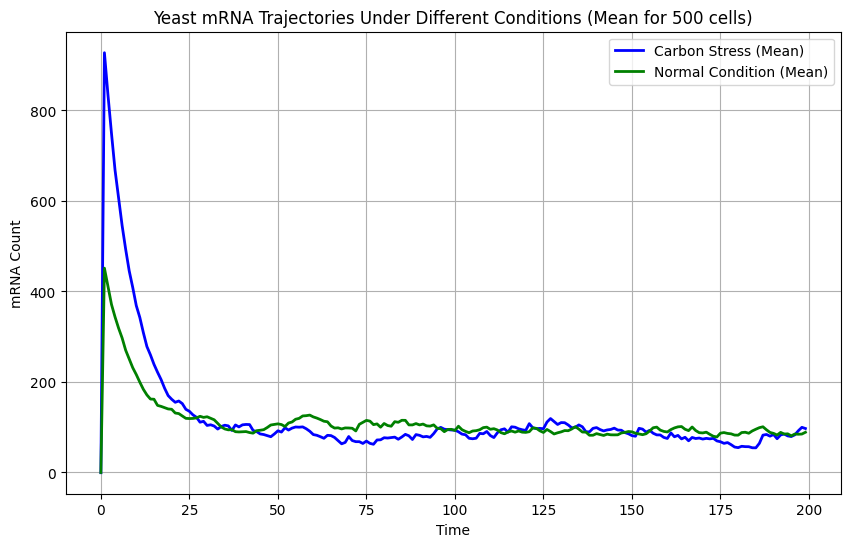

SVM Classification Accuracy: 0.68


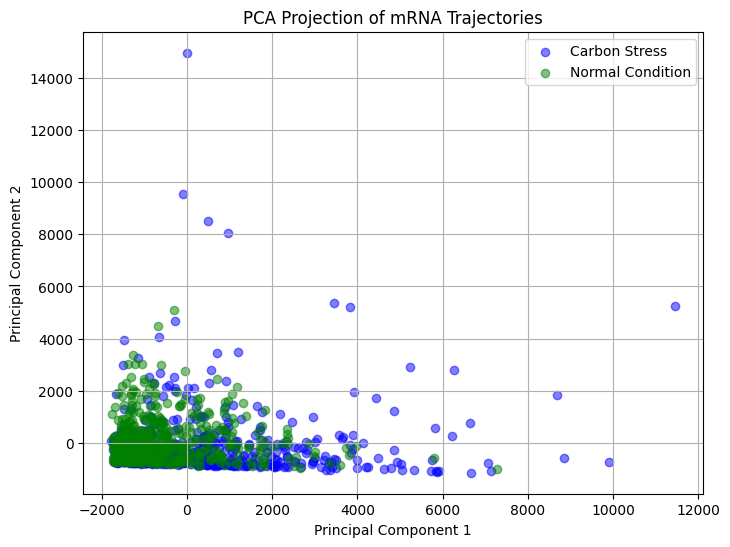

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Extract mRNA trajectories for each condition
stress_trajectories = df_results[df_results['label'] == 0].iloc[:, 1:].values  # Carbon stress
normal_trajectories = df_results[df_results['label'] == 1].iloc[:, 1:].values  # Normal condition

# Plot mRNA trajectories
fig, ax = plt.subplots(figsize=(10, 6))

# Plot mean trajectory for each condition
ax.plot(time_points, stress_trajectories.mean(axis=0), color='blue', label='Carbon Stress (Mean)', linewidth=2)
ax.plot(time_points, normal_trajectories.mean(axis=0), color='green', label='Normal Condition (Mean)', linewidth=2)

# Labels and legend
ax.set_xlabel("Time")
ax.set_ylabel("mRNA Count")
ax.set_title(f"Yeast mRNA Trajectories Under Different Conditions (Mean for {size} cells)")
ax.legend()
ax.grid(True)

# Show plot
plt.show()

#####################

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Load the mRNA trajectories dataset
df_results = pd.read_csv("~/stochastic_simulations/SSA_telegraph_model/traj_data/mRNA_trajectories_noised_adjusted_sigma.csv")

# Extract features (mRNA trajectories) and labels
X = df_results.iloc[:, 1:].values  # All time series data
y = df_results["label"].values  # Labels: 0 (Carbon Stress) or 1 (Normal Condition)

# Split data into training and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a basic SVM model without grid search
svm_model = SVC(C=1.0, gamma='scale', kernel='rbf')
svm_model.fit(X_train, y_train)

# Evaluate the model
y_pred = svm_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"SVM Classification Accuracy: {accuracy:.2f}")

# Scatter plot of two PCA components for visualization
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[y == 0, 0], X_pca[y == 0, 1], color='blue', label='Carbon Stress', alpha=0.5)
plt.scatter(X_pca[y == 1, 0], X_pca[y == 1, 1], color='green', label='Normal Condition', alpha=0.5)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Projection of mRNA Trajectories")
plt.legend()
plt.grid(True)
plt.show()